In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import datetime as dt
import sys
import os
import pandas as pd
import os.path as osp
import xarray as xr
from copy import copy
from matplotlib.offsetbox import AnchoredText
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
import datetime
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.io.img_tiles as cimgt
import pytz
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
oco2_target_dates = ['2022-05-10',
                     '2022-05-12',
                     '2022-06-26',
                     '2022-07-06',
                     '2022-07-15',
                     '2022-07-22',
                     '2022-07-29',
                     '2022-07-31',
                     '2022-08-07',
                     '2022-08-14',
                     '2022-08-16',
                     '2022-08-23',
                     '2022-09-01',
                     '2022-09-08',
                     '2022-09-17',
                     '2022-09-24',
                     '2022-10-03',
                     '2022-10-10',
                     '2022-11-04',
                     '2022-11-11',
                     '2022-11-27',
                     '2022-11-29',
                     '2022-12-13',
                     '2023-01-23',
                     '2023-01-30',
                     '2023-02-08',
                     '2023-02-24',
                     '2023-03-03',
                     '2023-03-19',
                     '2023-03-28',
                     '2023-04-04',
                     '2023-04-11',
                     '2023-04-13',
                     '2023-04-20',
                     '2023-04-27',
                     '2023-04-29',
                     '2023-05-06',
                     '2023-05-13',
                     '2023-05-15',
                     '2023-05-22',
                     '2023-05-29',
                     '2023-05-31',
                     '2023-06-16',
                     '2023-06-23',
                     '2023-07-02',
                     '2023-07-09',
                     '2023-07-18',
                     '2023-07-23',
                     '2023-07-25',
                     '2023-07-27',
                     '2023-08-01',
                     '2023-08-03',
                     '2023-08-10',
                     '2023-08-19',
                     '2023-08-26',
                     ]

oco3_target_dates = ['2023-04-08',
                     '2023-08-05',
                     '2023-08-09',
                     ]

oof_files =  os.listdir('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/')
oof_dateids = [x.split('.')[0][2:] for x in oof_files]

for date in sorted(oco2_target_dates):
    if date.replace('-','') in oof_dateids:
        pass
        #print(date)
    

In [3]:
oco2_data_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/OCO/OCO2/SLC_targets/'
oof_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/"
inst_loc = {'lat':40.768,'lon':-111.854}
map_extent=[-112.3,-111.5,40.5,41.0]
radius = 6000
oof_surround_time = datetime.timedelta(minutes=30)

In [4]:
def check_for_oco2_file(oco2_data_folder,date):
    oco2_date_str = datetime.datetime.strftime(date,'%y%m%d')
    oco2_filename = None
    for fname in os.listdir(oco2_data_folder):
        if oco2_date_str in fname:
            oco2_filename = fname
    return oco2_filename

def check_for_oof_file(oof_data_folder,date):
    oof_date_str = datetime.datetime.strftime(date,'%Y%m%d')
    oof_filename = None
    for fname in os.listdir(oof_data_folder):
        if oof_date_str in fname:
            oof_filename = fname
    return oof_filename

def get_oco2_within_radius(oco2_data_folder,oco2_filename,inst_loc,radius,initial_filter_deg = 1):
    xr_ds = xr.open_dataset(os.path.join(oco2_data_folder,oco2_filename))
    oco2_df = xr_ds[['xco2','time','latitude','longitude','xco2_quality_flag']].to_dataframe().reset_index(drop=True)
    oco2_df = oco2_df.loc[oco2_df['xco2_quality_flag']==0]
    oco2_subdf = oco2_df.loc[(oco2_df['longitude']>=inst_loc['lon']-initial_filter_deg)&
                             (oco2_df['longitude']<=inst_loc['lon']+initial_filter_deg)&
                             (oco2_df['latitude']>=inst_loc['lat']-initial_filter_deg)&
                             (oco2_df['latitude']<=inst_loc['lat']+initial_filter_deg)]
    if len(oco2_subdf)==0:
        return None
    oco2_subdf['dist_from_inst'] = np.vectorize(ac.haversine)(inst_loc['lat'],inst_loc['lon'],oco2_subdf['latitude'],oco2_subdf['longitude'])
    oco2_subdf['inradius'] = oco2_subdf.apply(lambda row: row['dist_from_inst']<=radius,axis = 1)
    oco2_inradius_df = oco2_subdf.loc[oco2_subdf['inradius']]
    if len(oco2_inradius_df)==0:
        return None
    return oco2_inradius_df

def get_oco2_details(oco2_df):
    describe_dict = dict(oco2_df['xco2'].describe())
    out_dict = {}
    for k,v in describe_dict.items():
        if k == 'count':
            out_dict['oco2_num_soundings'] = v
        else:
            out_dict[f'oco2_xco2_{k}'] = v
    out_dict['oco2_window_start'] = pytz.timezone('UTC').localize(min(oco2_inradius_df['time']))
    out_dict['oco2_window_end'] = pytz.timezone('UTC').localize(max(oco2_inradius_df['time']))
    return out_dict

def get_oof_within_window(oof_data_folder,oco2_window_start,oco2_window_end,oof_surround_time):
    oof_window_start = oco2_window_start-oof_surround_time
    oof_window_end = oco2_window_end+oof_surround_time
    my_oof_manager = ac.oof_manager(oof_data_folder,'UTC')
    oof_df = my_oof_manager.load_oof_df_inrange(oof_window_start,oof_window_end, filter_flag_0=True)
    if len(oof_df)==0:
        return None
    else: 
        return oof_df
    
def get_oof_details(oof_df):
    describe_dict = oof_df['xco2(ppm)'].describe()
    out_dict = {}
    for k,v in describe_dict.items():
        if k == 'count':
            out_dict['em27_num_obs'] = v
        else:
            out_dict[f'em27_xco2_{k}'] = v
    return out_dict

days_with_data = {}
for oco2_target_date in oco2_target_dates:
    date = datetime.datetime.strptime(oco2_target_date,'%Y-%m-%d')
    oof_filename = check_for_oof_file(oof_data_folder,date)
    oco2_filename = check_for_oco2_file(oco2_data_folder,date)
    if (oof_filename is not None) & (oco2_filename is not None):
        days_with_data[oco2_target_date] = {'oof_filename':oof_filename,'oco2_filename':oco2_filename}

oco2_em27_dict = {}
for day in days_with_data.keys():
    oco2_filename = days_with_data[day]['oco2_filename']
    oco2_inradius_df = get_oco2_within_radius(oco2_data_folder,oco2_filename,inst_loc,radius)
    if oco2_inradius_df is None:
        continue
    oco2_inradius_details = get_oco2_details(oco2_inradius_df)
    oof_df = get_oof_within_window(oof_data_folder,oco2_inradius_details['oco2_window_start'],oco2_inradius_details['oco2_window_end'],oof_surround_time)
    if oof_df is None:
        continue
    oof_inrange_details = get_oof_details(oof_df)
    appenddict = copy(oof_inrange_details)
    appenddict.update(oco2_inradius_details)
    oco2_em27_dict[day] = appenddict

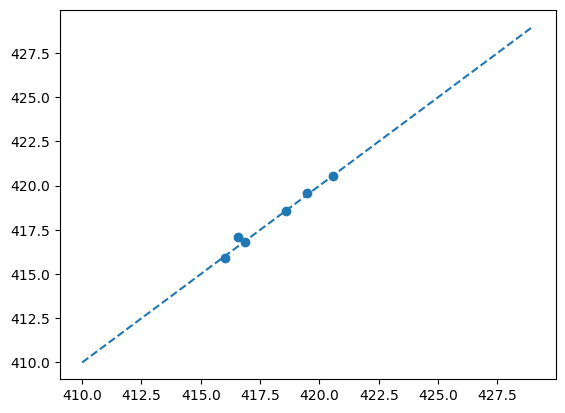

In [5]:
df = pd.DataFrame(oco2_em27_dict).transpose()
plt.scatter(df['em27_xco2_mean'],df['oco2_xco2_mean'])
plt.plot(range(410,430),range(410,430),'--')


# Plotting

In [6]:
day = '2022-07-29'
oco2_filename = days_with_data[day]['oco2_filename']

tz = 'UTC'
xr_ds = xr.open_dataset(os.path.join(oco2_data_folder,oco2_filename))

oco2_df = xr_ds[['xco2','time','latitude','longitude','xco2_quality_flag']].to_dataframe().reset_index(drop=True)
oco2_df = oco2_df.loc[oco2_df['xco2_quality_flag']==0]
oco2_subdf = oco2_df.loc[(oco2_df['longitude']>=map_extent[0])&
                (oco2_df['longitude']<=map_extent[1])&
                (oco2_df['latitude']>=map_extent[2])&
                (oco2_df['latitude']<=map_extent[3])]
if len(oco2_subdf)==0:
    raise Exception('No data in spatial domain')
oco2_subdf['dist_from_inst'] = np.vectorize(ac.haversine)(inst_loc['lat'],inst_loc['lon'],oco2_subdf['latitude'],oco2_subdf['longitude'])
oco2_subdf['inradius'] = oco2_subdf.apply(lambda row: row['dist_from_inst']<=radius,axis = 1)
oco2_inradius_df = oco2_subdf.loc[oco2_subdf['inradius']]
if len(oco2_inradius_df)==0:
    raise Exception('No data in spatial domain')
oco2_inradius_start_dt = pytz.timezone(tz).localize(min(oco2_inradius_df['time']))
oco2_inradius_end_dt = pytz.timezone(tz).localize(max(oco2_inradius_df['time']))
oco2_inradius_mean_xco2 = oco2_inradius_df['xco2'].mean()
oco2_inradius_num_soundings = len(oco2_inradius_df)

In [7]:
#Load the EM27 Data
surround_time = datetime.timedelta(minutes=30)
tz = 'UTC'
oof_filename = days_with_data[day]['oof_filename']


my_oof_manager = ac.oof_manager(oof_data_folder,tz)
oof_df = my_oof_manager.df_from_oof(os.path.join(oof_data_folder,oof_filename),fullformat = True,filter_flag_0=True)

oof_df['overpass_window'] = (oof_df.index>=oco2_inradius_start_dt-surround_time)&(oof_df.index<=oco2_inradius_end_dt+surround_time)

intime_oof_num = len(oof_df.loc[oof_df['overpass_window']])
intime_oof_mean_xco2 = oof_df.loc[oof_df['overpass_window']]['xco2(ppm)'].mean()

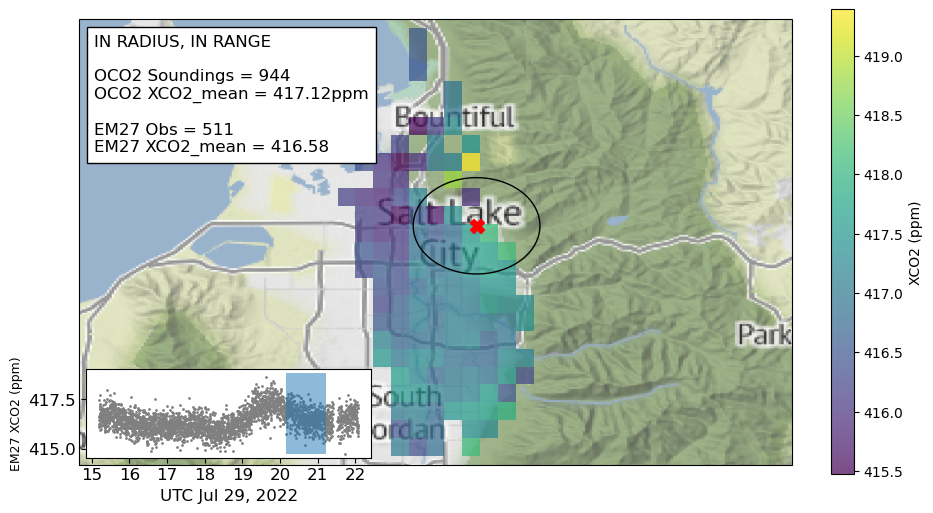

In [8]:
step = 0.02
to_bin = lambda x: np.floor(x/step)*step
oco2_subdf['latbin'] = to_bin(oco2_subdf['latitude'])
oco2_subdf['lonbin'] = to_bin(oco2_subdf['longitude'])
plot_xr = oco2_subdf.groupby(['latbin','lonbin']).mean(numeric_only=True).to_xarray()

labsize = 12
zoom = 1
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.set_extent(map_extent,crs=proj)
request = cimgt.Stamen(style='terrain')
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
ax.add_image(request,int(scale))

map = plot_xr['xco2'].plot.pcolormesh('lonbin','latbin',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)

ax.scatter(inst_loc['lon'],inst_loc['lat'],color = 'red',marker = 'X',s = 100)

cp = Geodesic().circle(lon=inst_loc['lon'],lat=inst_loc['lat'],radius = radius)
geom = sgeom.Polygon(cp)
ax.add_geometries(geom,crs=proj,edgecolor = 'k',facecolor='none')

text = f"IN RADIUS, IN RANGE\n\n\
OCO2 Soundings = {oco2_inradius_num_soundings}\n\
OCO2 XCO2_mean = {oco2_inradius_mean_xco2:.{2}f}ppm\n\n\
EM27 Obs = {intime_oof_num}\n\
EM27 XCO2_mean = {intime_oof_mean_xco2:.{2}f}"
at = AnchoredText(text, loc='upper left', frameon=True, borderpad=0.5, prop=dict(size=12))
ax.add_artist(at)

axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
axins.scatter(oof_df.index,oof_df['xco2(ppm)'],color = 'grey',zorder=3,s=1)
window_base = (min(oof_df.loc[oof_df['overpass_window']].index),min(oof_df['xco2(ppm)']))
width = max(oof_df.loc[oof_df['overpass_window']].index)-min(oof_df.loc[oof_df['overpass_window']].index)
height = max(oof_df['xco2(ppm)'])-min(oof_df['xco2(ppm)'])+0.2
rect = mpatches.Rectangle((window_base),width,height,zorder = 10,alpha = 0.5)
axins.add_patch(rect)
axins.tick_params(labelsize = labsize)
axins.set_ylabel('EM27 XCO2 (ppm)',size = labsize-3)
#axins.set_ylim([415,425])
axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = tz))
axins.set_xlabel(oof_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
plt.gcf().autofmt_xdate()

plt.colorbar(map,fraction=0.03,label ='XCO2 (ppm)')
plt.show()


# Jonathan

In [240]:
OCO2SAMS = glob.glob('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/OCO/OCO2/from_elaine/*.nc4')
OCO2SAMS.sort()

baselat = 40.76
baselon = -111.85
latrange = .2
lonrange = .3

latlow = baselat - latrange
lathigh = baselat + latrange
lonlow = baselon - lonrange
lonhigh = baselon + lonrange

datelist = []
co2list = []
em27list = []
em27error = []
ocoerror=[]
for SAM in OCO2SAMS:
    d = Dataset(SAM,'r')
    co2 = np.squeeze(d.variables['xco2'][:])
    #print(co2)
    co2qf = np.squeeze(d.variables['xco2_quality_flag'][:])
    #print(co2qf)
    #print(d.variables['vertex_longitude'][:,0])
    lon = np.squeeze(d.variables['vertex_longitude'][:,0])
    lat = np.squeeze(d.variables['vertex_latitude'][:,0])
    sec = np.squeeze(d.variables['time'][:])
    #print(co2m)
    co2m = np.ma.array(co2,mask=((co2qf!=1) | (lat<latlow) | (lat>lathigh) | (lon<lonlow) | (lon>lonhigh)))
    if len(co2m.compressed()) == 0:
        continue
    secm = np.ma.array(sec,mask=((co2qf!=1) | (lat<latlow) | (lat>lathigh) | (lon<lonlow) | (lon>lonhigh)))
    #print(secm)
    #print(secm.compressed())
    sec = np.mean(secm.compressed())
    #print(sec)
    date = dt.datetime(1970,1,1) + dt.timedelta(seconds=sec)
    #print(date)#print(np.mean(co2m))
    #sys.exit()
    print('{}: {} soundings, {} useable.  Mean CO2 of {}'.format(
        date.strftime('%Y%m%d'),len(co2),co2m.count(),np.mean(co2m)))
    if co2m.count() > 10.:

        datestr = date.strftime('%Y%m%d')
        fil = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/ha{0}.vav.ada.aia.oof'.format(datestr)
        if not(osp.exists(fil)):
           print('No EM27 data for {}'.format(datestr))
           continue
        temp = open(fil,'r')
        hnum = int(temp.readline().split()[0])-51
        print( hnum)
        temp.close()
        oof = pd.read_csv(fil,header=hnum,sep=' ',
                   skipinitialspace=True,parse_dates=[[2,3,4]],
                   date_parser=lambda *columns: dt.datetime(
                   int(columns[0][:-1]),1,1)+dt.timedelta(
                   days=int(columns[1][:-1])-1,
                   seconds=float(columns[2])*3600.))
        oof.rename(columns=lambda x: x.replace('(', '_'), inplace=True)
        oof.rename(columns=lambda x: x.replace(')', ''), inplace=True)

        oof.index = oof.year_day_hour
        oof = oof[oof.index > date-dt.timedelta(seconds=3600)]
        oof = oof[oof.index < date+dt.timedelta(seconds=3600)]
        quantiles = oof['xco2_ppm'].quantile([.25,.5,.75])
        emhigherr=quantiles[.75]-quantiles[.50]
        emlowerr=quantiles[.50]-quantiles[.25]
        #print(quantiles)
        #print(np.shape(quantiles))
        #print(quantiles[0.25])
        #sys.exit()
        datelist.append(date)
        mco2m = np.percentile(co2m.compressed(),50)
        ocohigh=np.percentile(co2m.compressed(),75)-mco2m
        ocolow=mco2m-np.percentile(co2m.compressed(),25)
        co2list.append(np.mean(co2m))
        em27list.append(quantiles[.50])
        em27error.append([emlowerr,emhigherr])
        ocoerror.append([ocolow,ocohigh])

20220510: 147180 soundings, 3141 useable.  Mean CO2 of 420.7976361031519
No EM27 data for 20220510
20220512: 152218 soundings, 1590 useable.  Mean CO2 of 419.2556603773585
No EM27 data for 20220512
20220629: 154233 soundings, 271 useable.  Mean CO2 of 420.643161900369
No EM27 data for 20220629
20220706: 139254 soundings, 1643 useable.  Mean CO2 of 420.4384129640901
251


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',
/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


20220729: 174838 soundings, 2337 useable.  Mean CO2 of 417.60849914420197
251
20220823: 188610 soundings, 1873 useable.  Mean CO2 of 418.1490589962627
251


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',
/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


20221003: 168011 soundings, 1451 useable.  Mean CO2 of 417.57972949689866
251
20221111: 149377 soundings, 1506 useable.  Mean CO2 of 421.1596945551129
251


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


20230328: 167503 soundings, 1024 useable.  Mean CO2 of 417.2680969238281
261


/tmp/ipykernel_1391706/2637035617.py:54: FutureWarning: 
        Use pd.to_datetime instead.

  oof = pd.read_csv(fil,header=hnum,sep=' ',


In [243]:
datelist

[datetime.datetime(2022, 7, 6, 20, 35, 17, 950531),
 datetime.datetime(2022, 7, 29, 20, 41, 13, 626628),
 datetime.datetime(2022, 8, 23, 20, 35, 2, 211831),
 datetime.datetime(2022, 10, 3, 20, 28, 48, 493719),
 datetime.datetime(2022, 11, 11, 20, 34, 21, 960279),
 datetime.datetime(2023, 3, 28, 20, 30, 12, 238141)]

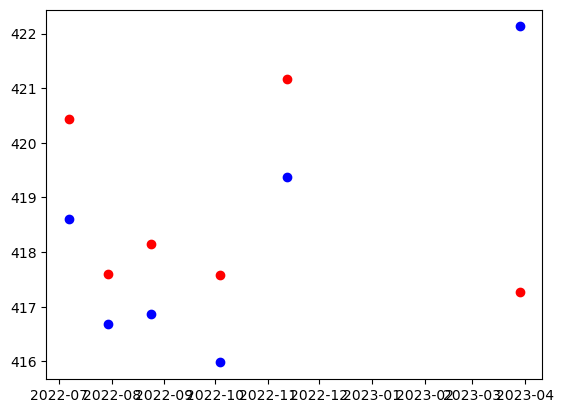

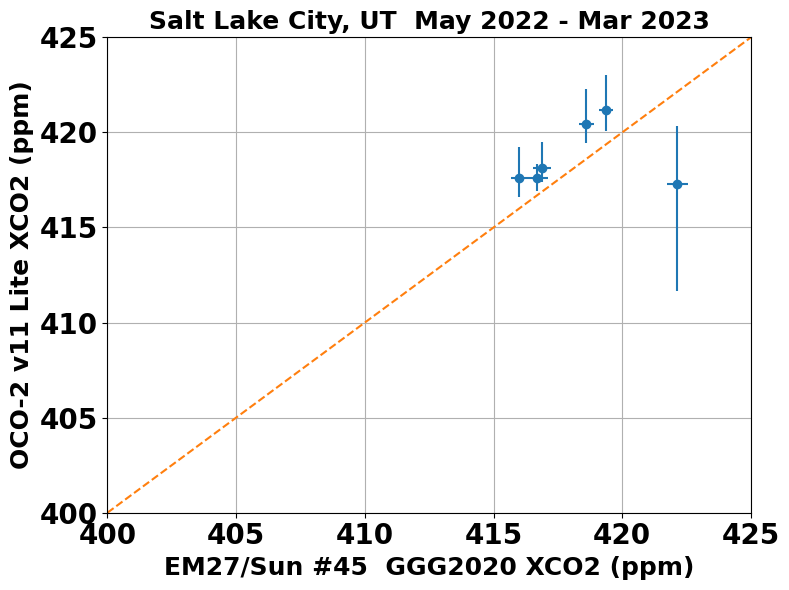

In [242]:
#for i in datelist:
#    print(i)
plt.plot(datelist,co2list,'ro')
plt.plot(datelist,em27list,'bo')
fig= plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
plt.errorbar(em27list,co2list,xerr=np.transpose(em27error),
        yerr=np.transpose(ocoerror),fmt='o')
plt.plot(range(400,450),range(400,450),'--')
plt.xlim([400,425])
plt.ylim([400,425])
plt.grid()
plt.xlabel('EM27/Sun #45  GGG2020 XCO2 (ppm)',fontsize=18,fontweight='bold')
plt.ylabel('OCO-2 v11 Lite XCO2 (ppm)',fontsize=18,fontweight='bold')
plt.title('Salt Lake City, UT  May 2022 - Mar 2023',fontsize=18,fontweight='bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(20)
    tick.label1.set_fontweight('bold')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(20)
    tick.label1.set_fontweight('bold')
fig.tight_layout()

plt.show()